# 30类水果图像分类-手机摄像头逐帧实时预测

同济子豪兄 2023-6-25

## 导入工具包

In [1]:
import cv2
import PIL
from cvs import *

import numpy as np

import aidlite_gpu

## 载入中文字体

In [2]:
from PIL import ImageFont, ImageDraw
# 导入中文字体，指定字号
font = ImageFont.truetype('data_meta/SimHei.ttf', 32)

## 加载TFLite模型

In [3]:
model_path = 'ckpt/resnet18_fruit30.tflite'

NUM_CLASS = 30 # 指定类别个数

In [4]:
aidlite = aidlite_gpu.aidlite()

# 模型路径 输入维度 输出维度 线程数 是否开启NNAPI
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_4fast_annmodel
aidlite.FAST_ANNModel(model_path, [256*256*3*4], [NUM_CLASS*4], 4, 0)

[2023-06-25 16:51:02,103184][/tmp/ipykernel_17466/2808051052.py:1 <module>][DEBUG]:=======init


Result(id=1, result='load model ok!', error=None)

## 载入类别名称与ID映射表

In [5]:
# 中文类别名称
idx_to_labels = np.load('data_meta/fruit30_idx_to_labels.npy', allow_pickle=True).item()

## 初始化摄像头

In [6]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [7]:
cap = cvs.VideoCapture(Camera_ID)

remi.server      INFO     Started httpserver http://0.0.0.0:14836/


('app runs on port:', 14836)
open the cam:0 ...


## 逐帧处理函数

In [8]:
def process_frame(img_bgr):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    ## numpy 转 pillow
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = PIL.Image.fromarray(img_rgb)
    
    ## 预处理
    img_tensor = cv2.resize(img_bgr, (256, 256)) # 尺寸缩放
    mean = (0.485, 0.456, 0.406) # 三通道的均值
    std = (0.229, 0.224, 0.225) # 三通道的标准差
    img_tensor = ((img_tensor / 255) - mean) / std
    img_tensor = img_tensor.astype('float32')
    
    ## 推理预测
    aidlite.setInput_Float32(img_tensor) # 装填数据
    aidlite.invoke() # 推理预测
    result = aidlite.getOutput_Float32() # 获得推理预测结果
    
    ## 解析预测结果
    pred_id = np.argmax(result) # 置信度最高类别 ID
    pred_class = idx_to_labels[pred_id] # 置信度最高类别名称
    
    ## 将预测类别名称写在图片上
    draw = ImageDraw.Draw(img_pil)
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100), pred_class, font=font, fill=(255, 0, 0, 1))
    
    img_rgb = np.array(img_pil)[:,:,::-1]
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR) # RGB转BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)
    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_output = cv2.putText(img_bgr, FPS_string, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return img_output

## 处理单帧画面

In [14]:
img_bgr = cap.read()

In [15]:
img_bgr.shape

(640, 480, 3)

In [16]:
img_output = process_frame(img_bgr)

In [19]:
cvs.imshow(img_output[:,:,::-1])

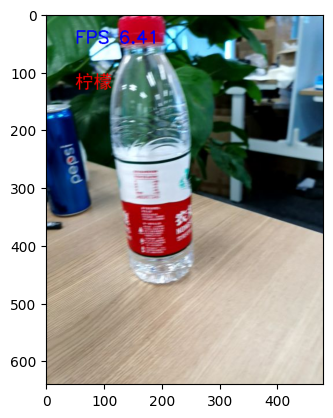

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_output)
plt.show()

## 逐帧实时处理手机摄像头拍摄的画面

In [ ]:
while True:
    
    img_bgr = cap.read()
    
    if img_bgr is None: # 如果拍摄到的图像为空，则跳过当前帧，重新拍摄
        continue
    else:
        img_output = process_frame(img_bgr)
        cvs.imshow(img_output[:,:,::-1])

## 点击`重启kernel`关闭摄像头